In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np

import pyabf
import tifffile

In [2]:
denoised_movie = np.load('/home/jupyter/bw-data/cellmincer/data/cell_3_1_MMStack_Pos0/denoised_movie_tyx.npy').transpose((0, 2, 1))

In [3]:
denoised_movie.shape

(5000, 512, 100)

In [4]:
save_fig = True
fig_suffix = 'cell_3_1'

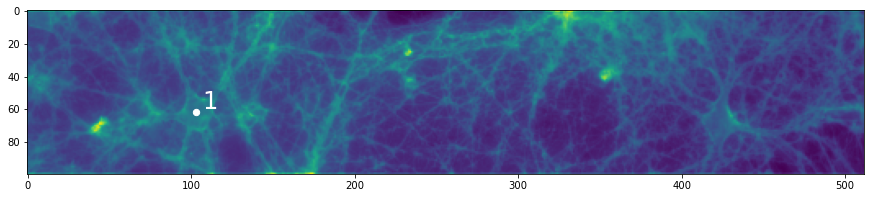

In [5]:
pixs = [(103, 62)]

frame = denoised_movie[1200].copy()
plt.figure(figsize=(15, 12))
plt.imshow(frame.T)
for i, pix in enumerate(pixs):
    plt.text(pix[0] + 4, pix[1] - 2, f'{i + 1}', color='white', fontsize=24)
plt.scatter(*list(zip(*pixs)), color='white', s=40)
if save_fig:
    plt.savefig(f'neuron_pix{fig_suffix}.png')
plt.show()

In [6]:
denoised_movie_z = (denoised_movie - denoised_movie.mean(axis=0)) / denoised_movie.std(axis=0)

pix = pixs[0]
cor = np.apply_along_axis(np.correlate, 0, denoised_movie_z, v=denoised_movie_z[:, pix[0], pix[1]])[0] / len(denoised_movie_z)

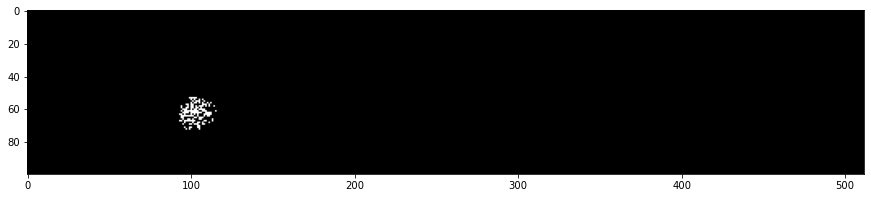

In [7]:
plt.figure(figsize=(15, 5))
plt.imshow((cor > 0.97).T, cmap='gray')
plt.show()

In [8]:
raw = tifffile.imread('/home/jupyter/bw-data/miller-ephys/standard_imaging/id_170802_cell_3/cell_3_1_MMStack_Pos0.ome.tif').transpose((0, 2, 1))
abf = pyabf.ABF('/home/jupyter/bw-data/miller-ephys/standard_imaging/id_170802_cell_3/17802002.abf')
abf.setSweep(0)

x_soma, y_soma = np.nonzero(cor > 0.97)
denoised_region = denoised_movie[..., x_soma, y_soma].mean(axis=1)

In [9]:
denoised_region.shape

(5000,)

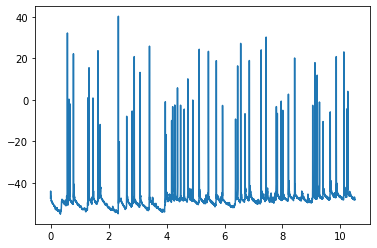

In [16]:
abf_dsX = np.linspace(0, 10.5, num=len(denoised_movie), endpoint=False)
abf_dsY = np.interp(x=abf_dsX, xp=abf.sweepX, fp=abf.sweepY)

plt.figure()
plt.plot(abf_dsX, abf_dsY)
plt.show()

In [14]:
min(abf.sweepX)

0.0

In [ ]:
begin, end = 0.6, 0.7
i_frame_begin, i_frame_end = int(len(raw) * begin), int(len(raw) * end)
i_ephys_begin, i_ephys_end = int(len(abf.sweepX) * begin), int(len(abf.sweepX) * end)
offset = 0

pix = pixs[0]

# np.argmax(np.correlate(denoised_movie[:, pix[0], pix[1]]), abf.)

fig, axs = plt.subplots(3, figsize=(20, 12))

# axs[0].plot(np.arange(i_frame_begin, i_frame_end), raw[i_frame_begin+offset:i_frame_end+offset, pix[0], pix[1]])
axs[0].plot(np.arange(i_frame_begin, i_frame_end), denoised_movie[i_frame_begin+offset:i_frame_end+offset, pix[0], pix[1]])
axs[1].plot(np.arange(i_frame_begin, i_frame_end), denoised_region[i_frame_begin+offset:i_frame_end+offset])
axs[2].plot(abf.sweepX[i_ephys_begin:i_ephys_end], abf.sweepY[i_ephys_begin:i_ephys_end])

# axs[0].set_title('raw', size=16)
axs[0].set_title('denoised pixel', size=16)
axs[1].set_title('denoised region', size=16)
axs[2].set_title('patch clamp', size=16)

fig.tight_layout()

if save_fig:
    fig.savefig(f'/home/jupyter/bw-data/tmp/pix_with_ephys_{fig_suffix}.png')
fig.show()

In [ ]:
abf.sweepX[-10:]

In [ ]:
from skvideo import io as skio
from matplotlib.colors import Normalize
import matplotlib.pylab as plt
import numpy as np
import torch
from typing import List, Optional

def normalize_movie(
        movie_txy: np.ndarray,
        n_sigmas: Optional[float] = 8,
        max_intensity=255):
    z_movie_txy  = (movie_txy - movie_txy.mean()) / movie_txy.std()
    norm = Normalize(vmin=0, vmax=n_sigmas, clip=True)
    return max_intensity * norm(z_movie_txy)

In [ ]:
raw_norm_txy = normalize_movie(
    raw,
    n_sigmas=5)

writer = skio.FFmpegWriter(
    '/home/jupyter/bw-data/tmp/raw.avi',
    outputdict={'-vcodec': 'rawvideo', '-pix_fmt': 'yuv420p', '-r': '60'})

for i_frame in range(len(raw_norm_txy)):
    writer.writeFrame(raw_norm_txy[i_frame].T[None, ...])
writer.close()